In [1]:
import tensorflow as tf
#import wave
import glob
import scipy.io.wavfile as wavfile
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
global SMP_RATE
SMP_RATE = 16000

In [3]:
def getWaveName(wavepath):
    return wavepath.split('/')[-1]

def findWave(wavefile,path):
    r = glob.glob(path+wavefile)
    return r[0]

In [4]:
fpath = '../data/female_us/'
mpath = '../data/male_us/'

In [5]:
#male
result = []
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    result.append(wav_data.shape[0]/(1.0*fm))
    assert fm == SMP_RATE
resultm = np.array(result)

#female
result = []
for filename in glob.glob(fpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    result.append(wav_data.shape[0]/(1.0*fm))
    assert fm == SMP_RATE
resultf = np.array(result)

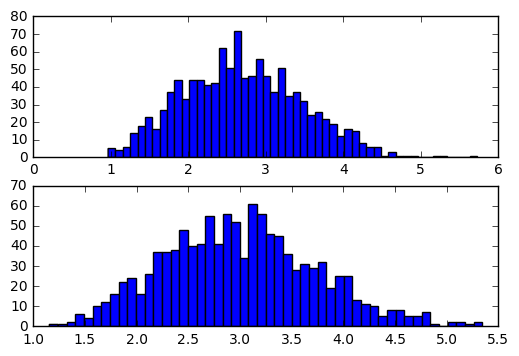

In [6]:
plt.subplot(211)
plt.hist(resultm,bins=50)
plt.subplot(212)
plt.hist(resultf,bins=50)
plt.show()

# Hacky parallel dataset

In [7]:
# map male to female
m2f = dict()
for i in glob.glob(mpath+'/*.wav'):
    m2f[i]=findWave(getWaveName(i),fpath)

In [8]:
m2f.keys()[0]

'../data/male_us/arctic_a0058.wav'

# Bin before hand

In [9]:
bin_size_x = (2,3)
bin_size_y = (2,3)

In [10]:
bin_mapping = {}
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    size = wav_data.shape[0]/(1.0*fm)
    if size < bin_size_x[1] and size > bin_size_x[0]:
        fm2, wav_data2 = wavfile.read(m2f[filename])
        size2 = wav_data2.shape[0]/(1.0*fm2)
        if size2 < bin_size_x[1] and size2 > bin_size_x[0]:
            bin_mapping[filename] = m2f[filename]

In [11]:
len(bin_mapping)

348

# Sec to Samples

In [12]:
def sec2samp(sec,smp_rate):
    return int(sec*smp_rate)

# Padding

In [13]:
def padTo(x,size,kind='SYM'):
    """
    Expects 1D array
    """
    assert kind in ['LEFT','RIGHT','SYM']
    if kind == 'LEFT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((pad,x),axis=0)
    elif kind == 'RIGHT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((x,pad),axis=0)
    elif kind == 'SYM':
        padl = np.zeros((size-len(x))/2,dtype=x.dtype)
        padr = np.zeros((size-len(x))/2+(size-len(x))%2,dtype=x.dtype)
        r = np.concatenate((padl,x,padr),axis=0)
    return r

In [14]:
padTo(np.array([1,2,3]),6,kind='LEFT')

array([0, 0, 0, 1, 2, 3])

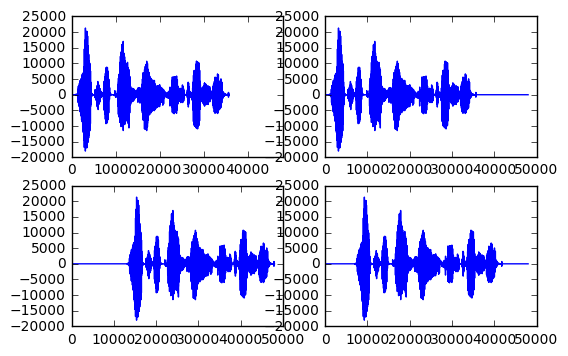

In [15]:
_,x = wavfile.read(bin_mapping.keys()[0])
plt.subplot(221)
plt.plot(x)
plt.xlim(0,SMP_RATE*bin_size_x[1])
plt.subplot(222)
plt.plot(padTo(x,SMP_RATE*bin_size_x[1],kind='RIGHT'))
plt.subplot(223)
plt.plot(padTo(x,SMP_RATE*bin_size_x[1],kind='LEFT'))
plt.subplot(224)
plt.plot(padTo(x,SMP_RATE*bin_size_x[1]))
plt.show()

# Batch Generator

convolution expects data of shape (batchsize,height,width,inchannel)

Data should be of shape (batchsize,height=1,time_length (this is width),inchannel=1)

In [38]:
class Batch(object):
    def __init__(self,mapping,bin_max,batch_size=1):
        self.mapping = mapping
        self.bin_max = bin_max
        self.batch_size = batch_size
        self.seq_size = self.bin_max*SMP_RATE
        self.shape = (self.batch_size,1,self.seq_size,1)
        self.x_list = mapping.keys()
        self.size = len(self.x_list) #data size
        self.cursors = [(self.size//self.batch_size)*i for i in range(self.batch_size)]
        
    def getBatch(self):
        #get the file names
        x_path = [self.x_list[c] for c in self.cursors]
        y_path = [self.mapping[xp] for xp in x_path]
        
        #Get the x,y files and pad
        x = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        y = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        for i,(xp,yp) in enumerate(zip(x_path,y_path)):
            _,x_raw=wavfile.read(xp)
            _,y_raw=wavfile.read(yp)
            x_pad = padTo(x_raw,self.bin_max*SMP_RATE)
            y_pad = padTo(y_raw,self.bin_max*SMP_RATE)
            x[i,0,:,0]=x_pad
            y[i,0,:,0]=y_pad
            
        #update cursor positions
        self.cursors = [(c+1)%self.size for c in self.cursors]
        return (x,y)

In [39]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=3)

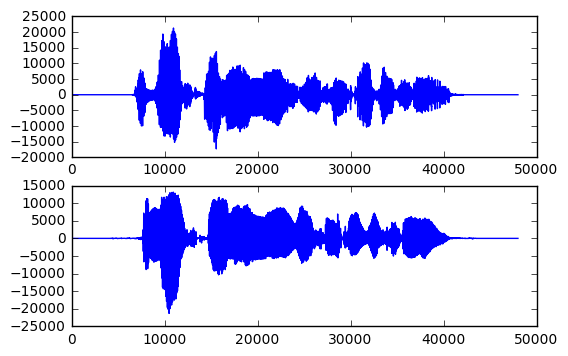

In [40]:
tempx,tempy = b.getBatch()
plt.subplot(211)
plt.plot(tempx[2,0,:,0])
plt.subplot(212)
plt.plot(tempy[2,0,:,0])

In [41]:
print tempx.shape
print tempy.shape

(3, 1, 48000, 1)
(3, 1, 48000, 1)


# PReLU

In [108]:
def prelu(x,name='prelu'):
    in_shape = x.get_shape().as_list()
    with tf.variable_scope(name):
        alpha = tf.get_variable('alpha',in_shape[-1],
                               initializer=tf.constant_initializer(0.),
                               dtype=tf.float32)
        pos = tf.nn.relu(x)
        neg = alpha * (x-tf.abs(x))*.5
        
        return pos + neg
    
# def PReLU(x,alpha,beta):
#     return alpha*tf.maximum(0,x)

# 1D Convolutions on 4D inputs using 2D convolution function

In [109]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=3)

In [204]:
g = tf.Graph()
with g.as_default():
    #try None shapes
    x = tf.placeholder(tf.float32,shape=b.shape)
    y = tf.placeholder(tf.float32,shape=b.shape)
    
#     conv1=tf.get_variable('conv1',shape=[1,31,1,1],initializer=tf.random_normal_initializer(0,.1))
#     result=tf.nn.conv2d(x,conv1,strides=[1,1,2,1],padding='VALID')
    
    #create variables
    with tf.variable_scope('in'):
        # Shape (height,width,inchannels,out_channels)
        conv1=tf.get_variable('conv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.1))
        conv2=tf.get_variable('conv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.1))
        conv3=tf.get_variable('conv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.1))
        conv4=tf.get_variable('conv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.1))
        conv5=tf.get_variable('conv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.1))
        conv6=tf.get_variable('conv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.1))
        conv7=tf.get_variable('conv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.1))
        conv8=tf.get_variable('conv8',shape=[1,31,128,128],initializer=tf.truncated_normal_initializer(0,.1))
        conv9=tf.get_variable('conv9',shape=[1,31,128,256],initializer=tf.truncated_normal_initializer(0,.1))
        conv10=tf.get_variable('conv10',shape=[1,31,256,256],initializer=tf.truncated_normal_initializer(0,.1))

        
    #do operations
    with tf.variable_scope('l1'):
        l1=prelu(tf.nn.conv2d(x,conv1,strides=[1,1,2,1],padding='SAME'))
    with tf.variable_scope('l2'):
        l2=prelu(tf.nn.conv2d(l1,conv2,strides=[1,1,2,1],padding='SAME'))
    with tf.variable_scope('l3'):
        l3=prelu(tf.nn.conv2d(l2,conv3,strides=[1,1,2,1],padding='SAME'))
    with tf.variable_scope('l4'):
        l4=prelu(tf.nn.conv2d(l3,conv4,strides=[1,1,2,1],padding='SAME'))
    with tf.variable_scope('l5'):
        l5=prelu(tf.nn.conv2d(l4,conv5,strides=[1,1,2,1],padding='SAME'))
    with tf.variable_scope('l6'):
        l6=prelu(tf.nn.conv2d(l5,conv6,strides=[1,1,2,1],padding='SAME'))
    with tf.variable_scope('l7'):
        l7=prelu(tf.nn.conv2d(l6,conv7,strides=[1,1,2,1],padding='SAME'))
    with tf.variable_scope('l8'):
        l8=prelu(tf.nn.conv2d(l7,conv8,strides=[1,1,2,1],padding='SAME'))
    with tf.variable_scope('l9'):
        l9=prelu(tf.nn.conv2d(l8,conv9,strides=[1,1,2,1],padding='SAME'))
    with tf.variable_scope('l10'):
        l10=prelu(tf.nn.conv2d(l9,conv10,strides=[1,1,2,1],padding='SAME'))
        
    
    # Transpose Convolution
    with tf.variable_scope('out'):
        # Shape (height,width,out_channels,input channels)
        dconv10 = tf.get_variable('dconv10',shape=[1,31,256,256],initializer=tf.truncated_normal_initializer(0,.1))
        dconv9 = tf.get_variable('dconv9',shape=[1,31,128,256],initializer=tf.truncated_normal_initializer(0,.1))
        dconv8 = tf.get_variable('dconv8',shape=[1,31,128,128],initializer=tf.truncated_normal_initializer(0,.1))
        dconv7 = tf.get_variable('dconv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.1))
        dconv6 = tf.get_variable('dconv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.1))
#         conv1=tf.get_variable('conv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.1))
#         conv2=tf.get_variable('conv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.1))
#         conv3=tf.get_variable('conv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.1))
#         conv4=tf.get_variable('conv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.1))
#         conv5=tf.get_variable('conv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.1))
#         conv6=tf.get_variable('conv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.1))
#         conv7=tf.get_variable('conv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.1))
#         conv8=tf.get_variable('conv8',shape=[1,31,128,128],initializer=tf.truncated_normal_initializer(0,.1))
#         conv9=tf.get_variable('conv9',shape=[1,31,128,256],initializer=tf.truncated_normal_initializer(0,.1))
#         conv10=tf.get_variable('conv10',shape=[1,31,256,256],initializer=tf.truncated_normal_initializer(0,.1))
#     with tf.variable_scope('dl10'):
        dl10 = tf.nn.conv2d_transpose(l10,dconv10,output_shape=[b.batch_size,1,2*47,256],strides=[1,1,2,1])
        dl9 = tf.nn.conv2d_transpose(dl10,dconv9,output_shape=[b.batch_size,1,2*2*47,128],strides=[1,1,2,1])
    
#     l1=tf.nn.relu(tf.nn.conv2d(x,conv1,strides=[1,1,2,1],padding='VALID'))
#     l2=tf.nn.relu(tf.nn.conv2d(l1,conv2,strides=[1,1,2,1],padding='VALID'))
#     l3=tf.nn.relu(tf.nn.conv2d(l2,conv3,strides=[1,1,2,1],padding='VALID'))
#     l4=tf.nn.relu(tf.nn.conv2d(l3,conv4,strides=[1,1,2,1],padding='VALID'))
#     l5=tf.nn.relu(tf.nn.conv2d(l4,conv5,strides=[1,1,2,1],padding='VALID'))
#     l6=tf.nn.relu(tf.nn.conv2d(l5,conv6,strides=[1,1,2,1],padding='VALID'))

    init = tf.initialize_all_variables()

In [205]:
sess = tf.Session(graph=g)
sess.run(init)
x_data,y_data = b.getBatch()
fd = {x:x_data,y:y_data}
result = sess.run(dl9,feed_dict=fd)
result.shape

(3, 1, 188, 128)

In [138]:
for i in g.get_collection('trainable_variables'):
    print i.name

in/conv1:0
in/conv2:0
in/conv3:0
in/conv4:0
in/conv5:0
in/conv6:0
in/conv7:0
in/conv8:0
l1/prelu/alpha:0
l2/prelu/alpha:0
l3/prelu/alpha:0
l4/prelu/alpha:0
l5/prelu/alpha:0
l6/prelu/alpha:0
l7/prelu/alpha:0
l8/prelu/alpha:0


In [107]:
print result

[[[[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]]


 [[[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]]


 [[[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]]]


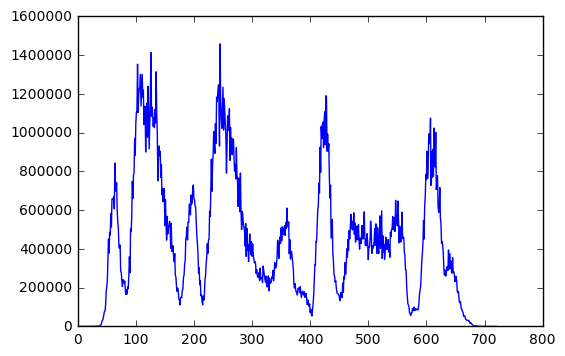

In [88]:
plt.plot(np.sum(result[0,0,:,:],axis=1))